In [1]:
import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"

In [14]:
import jax
import jax.numpy as jnp
import equinox as eqx
import numpy as np
import pandas as pd
import distrax
import wandb
import optax
import chex

import abc
from typing import Optional, Callable, Union, Tuple, Dict, Any, Sequence, List
from itertools import product

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

from IPython.display import HTML



plt.rcParams["figure.dpi"] = 300
plt.rcParams["figure.figsize"] = [6.0, 4.0]

key = jax.random.PRNGKey(12391)



### Target Density

In [3]:
def plot_contours_2D(
    log_prob_func, ax: Optional[plt.Axes] = None, bound: float = 3, levels: int = 20
):
    """Plot the contours of a 2D log prob function."""
    if ax is None:
        fig, ax = plt.subplots(1)
    n_points = 200
    x_points_dim1 = np.linspace(-bound, bound, n_points)
    x_points_dim2 = np.linspace(-bound, bound, n_points)
    x_points = np.array(list(product(x_points_dim1, x_points_dim2)))
    log_probs = log_prob_func(x_points)
    log_probs = jnp.clip(log_probs, a_min=-1000, a_max=None)
    x1 = x_points[:, 0].reshape(n_points, n_points)
    x2 = x_points[:, 1].reshape(n_points, n_points)
    z = log_probs.reshape(n_points, n_points)
    ax.contour(x1, x2, z, levels=levels)

def plot_contours_2D_with_time(
    log_prob_func: Callable[[np.ndarray, float], np.ndarray],
    t: float,
    ax: Optional[plt.Axes] = None,
    bound: float = 3,
    levels: int = 20
):
    """Plot the contours of a 2D log prob function at time t."""
    if ax is None:
        fig, ax = plt.subplots(1, figsize=(6,6))
    ax.clear()  # Clear previous contours
    n_points = 200
    x_points_dim1 = np.linspace(-bound, bound, n_points)
    x_points_dim2 = np.linspace(-bound, bound, n_points)
    x_points = np.array(list(product(x_points_dim1, x_points_dim2)))
    log_probs = log_prob_func(x_points, t)
    log_probs = jnp.clip(log_probs, a_min=-1000, a_max=None)
    x1 = x_points[:, 0].reshape(n_points, n_points)
    x2 = x_points[:, 1].reshape(n_points, n_points)
    z = log_probs.reshape(n_points, n_points)
    contour = ax.contourf(x1, x2, z, levels=levels, cmap='viridis')
    ax.set_title(f"Time t = {t:.2f}")
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    return contour


def plot_marginal_pair(
    samples: chex.Array,
    ax: Optional[plt.Axes] = None,
    marginal_dims: Tuple[int, int] = (0, 1),
    bounds: Tuple[float, float] = (-5, 5),
    alpha: float = 0.5,
):
    """Plot samples from marginal of distribution for a given pair of dimensions."""
    if not ax:
        fig, ax = plt.subplots(1)
    samples = jnp.clip(samples, bounds[0], bounds[1])
    ax.plot(
        samples[:, marginal_dims[0]], samples[:, marginal_dims[1]], "o", alpha=alpha
    )


def plot_history(history):
    """Agnostic history plotter for quickly plotting a dictionary of logging info."""
    figure, axs = plt.subplots(len(history), 1, figsize=(7, 3 * len(history.keys())))
    if len(history.keys()) == 1:
        axs = [axs]  # make iterable
    elif len(history.keys()) == 0:
        return
    for i, key in enumerate(history):
        data = pd.Series(history[key])
        data.replace([np.inf, -np.inf], np.nan, inplace=True)
        if sum(data.isna()) > 0:
            data = data.dropna()
            print(f"NaN encountered in {key} history")
        axs[i].plot(data)
        axs[i].set_title(key)
    plt.tight_layout()


LogProbFn = Callable[[chex.Array], chex.Array]


def calculate_log_forward_ess(
    log_w: chex.Array, mask: Optional[chex.Array] = None, log_Z: Optional[float] = None
) -> chex.Array:
    """Calculate forward ess, either using exact log_Z if it is known, or via estimating it from the samples.
    NB: log_q = p(x)/q(x) where x ~ p(x).
    """
    if mask is None:
        mask = jnp.ones_like(log_w)

    chex.assert_equal_shape((log_w, mask))
    log_w = jnp.where(mask, log_w, jnp.zeros_like(log_w))  # make sure log_w finite

    if log_Z is None:
        log_z_inv = jax.nn.logsumexp(-log_w, b=mask) - jnp.log(jnp.sum(mask))
    else:
        log_z_inv = -log_Z

    # log ( Z * E_p[p(x)/q(x)] )
    log_z_times_expectation_p_of_p_div_q = jax.nn.logsumexp(log_w, b=mask) - jnp.log(
        jnp.sum(mask)
    )
    # ESS (as fraction of 1) = 1/E_p[p(x)/q(x)]
    # ESS = Z / ( Z * E_p[p(x)/q(x)] )
    # Log ESS = - log Z^{-1} -  log ( Z * E_p[p(x)/q(x)] )
    log_forward_ess = -log_z_inv - log_z_times_expectation_p_of_p_div_q
    return log_forward_ess


class Target(abc.ABC):
    """Abstraction of target distribution that allows our training and evaluation scripts to be generic."""

    def __init__(
        self,
        dim: int,
        log_Z: Optional[float],
        can_sample: bool,
        n_plots: int,
        n_model_samples_eval: int,
        n_target_samples_eval: Optional[int],
    ):
        self.n_model_samples_eval = n_model_samples_eval
        self.n_target_samples_eval = n_target_samples_eval
        self._dim = dim
        self._log_Z = log_Z
        self._n_plots = n_plots
        self._can_sample = can_sample

    @property
    def dim(self) -> int:
        """Dimensionality of the problem."""
        return self._dim

    @property
    def n_plots(self) -> int:
        """Number of matplotlib axes that samples are visualized on."""
        return self._n_plots

    @property
    def can_sample(self) -> bool:
        """Whether the target may be sampled form."""
        return self._can_sample

    @property
    def log_Z(self) -> Union[int, None]:
        """Log normalizing constant if available."""
        return self._log_Z

    def sample(self, seed: chex.PRNGKey, sample_shape: chex.Shape) -> chex.Array:
        raise NotImplementedError

    @abc.abstractmethod
    def log_prob(self, value: chex.Array) -> chex.Array:
        """(Possibly unnormalized) target probability density."""

    def evaluate(
        self,
        model_log_prob_fn: LogProbFn,
        model_sample_and_log_prob_fn: Callable[
            [chex.PRNGKey, chex.Shape], Tuple[chex.Array, chex.Array]
        ],
        key: chex.PRNGKey,
    ) -> dict:
        """Evaluate a model. Note that reverse ESS will be estimated separately, so should not be estimated here."""
        key1, key2 = jax.random.split(key)

        info = {}

        if self.can_sample:
            assert self.n_target_samples_eval is not None
            samples_p = self.sample(key1, (self.n_target_samples_eval,))
            log_prob_q = model_log_prob_fn(samples_p)
            log_prob_p = self.log_prob(samples_p)
            log_w = log_prob_p - log_prob_q
            log_forward_ess = calculate_log_forward_ess(log_w, log_Z=self.log_Z)
            info.update(
                log_lik=jnp.mean(log_prob_q),
                log_forward_ess=log_forward_ess,
                forward_ess=jnp.exp(log_forward_ess),
            )
        return info

    @abc.abstractmethod
    def visualise(
        self,
        samples: chex.Array,
        axes: List[plt.Axes],
    ) -> None:
        """Visualise samples from the model."""

In [4]:
class GaussianMixture2D(Target):
    """
    2-D Guassian mixture.
    https://arxiv.org/abs/2310.02679
    https://github.com/zdhNarsil/Diffusion-Generative-Flow-Samplers/blob/main/target/distribution/gm.py
    """

    def __init__(self, scale=0.5477222, width_in_n_modes: int = 3):
        dim = 2
        super().__init__(
            dim=dim,
            log_Z=0.0,
            can_sample=True,
            n_plots=1,
            n_model_samples_eval=1000,
            n_target_samples_eval=2000,
        )
        means_1_dim = jnp.arange(width_in_n_modes) * 5
        means_1_dim = means_1_dim - jnp.mean(means_1_dim)  # Centre
        mean_ls = list(product(list(means_1_dim), list(means_1_dim)))

        nmode = len(mean_ls)
        mean = jnp.stack([jnp.array(xy) for xy in mean_ls])
        comp = distrax.Independent(
            distrax.Normal(loc=mean, scale=jnp.ones_like(mean) * scale),
            reinterpreted_batch_ndims=1,
        )
        mix = distrax.Categorical(logits=jnp.ones(nmode))
        self.gmm = distrax.MixtureSameFamily(
            mixture_distribution=mix, components_distribution=comp
        )
        self._plot_bound = mean.max() + 3

    def log_prob(self, x):
        log_prob = self.gmm.log_prob(x)
        return log_prob

    def sample(self, seed, sample_shape):
        return self.gmm.sample(seed=seed, sample_shape=sample_shape)

    def visualise(
        self,
        samples: chex.Array,
        axes: List[plt.Axes],
    ) -> None:
        """Visualise samples from the model."""
        assert len(axes) == self.n_plots

        ax = axes[0]
        plot_contours_2D(self.log_prob, ax, bound=self._plot_bound, levels=20)
        plot_marginal_pair(samples, ax, bounds=(-self._plot_bound, self._plot_bound))


class GMM(Target):
    def __init__(
        self,
        dim: int = 2,
        n_mixes: int = 40,
        loc_scaling: float = 40,
        scale_scaling: float = 1.0,
        seed: int = 0,
    ) -> None:
        super().__init__(
            dim=dim,
            log_Z=0.0,
            can_sample=True,
            n_plots=1,
            n_model_samples_eval=1000,
            n_target_samples_eval=1000,
        )

        self.seed = seed
        self.n_mixes = n_mixes

        key = jax.random.PRNGKey(seed)
        logits = jnp.ones(n_mixes)
        mean = (
            jax.random.uniform(shape=(n_mixes, dim), key=key, minval=-1.0, maxval=1.0)
            * loc_scaling
        )
        scale = jnp.ones(shape=(n_mixes, dim)) * scale_scaling

        mixture_dist = distrax.Categorical(logits=logits)
        components_dist = distrax.Independent(
            distrax.Normal(loc=mean, scale=scale), reinterpreted_batch_ndims=1
        )
        self.distribution = distrax.MixtureSameFamily(
            mixture_distribution=mixture_dist,
            components_distribution=components_dist,
        )

        self._plot_bound = loc_scaling * 1.5

    def log_prob(self, x: chex.Array) -> chex.Array:
        log_prob = self.distribution.log_prob(x)
        return log_prob

    def sample(self, seed: chex.PRNGKey, sample_shape: chex.Shape = ()) -> chex.Array:
        return self.distribution.sample(seed=seed, sample_shape=sample_shape)

    def visualise(
        self,
        samples: chex.Array,
        axes: List[plt.Axes],
    ) -> None:
        """Visualise samples from the model."""
        assert len(axes) == self.n_plots
        ax = axes[0]
        plot_marginal_pair(samples, ax, bounds=(-self._plot_bound, self._plot_bound))
        if self.dim == 2:
            plot_contours_2D(self.log_prob, ax, bound=self._plot_bound, levels=50)

In [5]:
class MultivariateGaussian(Target):
    """
    Multivariate Gaussian Distribution with Sigma * I covariance.

    Parameters:
    - dim: int
        Dimensionality of the Gaussian.
    - sigma: float or jnp.ndarray, default=1.0
        Standard deviation of the distribution. If a float is provided, the same sigma is used for all dimensions.
        If an array is provided, it should have shape (dim,) for per-dimension sigma.
    - plot_bound_factor: float, default=3.0
        Factor to determine the plotting bounds based on sigma.
    """

    def __init__(
        self, dim: int = 2, sigma: float = 1.0, plot_bound_factor: float = 3.0, **kwargs
    ):
        """
        Initializes the MultivariateGaussian distribution.

        Args:
            dim (int): Dimensionality of the Gaussian.
            sigma (float or jnp.ndarray): Standard deviation(s). Scalar for isotropic, array for anisotropic.
            plot_bound_factor (float): Factor to determine the plotting bounds.
            **kwargs: Additional arguments to pass to the base Target class.
        """
        super().__init__(
            dim=dim,
            log_Z=0.0,  # Not used since it's a single Gaussian
            can_sample=True,
            n_plots=1,
            n_model_samples_eval=1000,
            n_target_samples_eval=1000,
            **kwargs,
        )

        self.sigma = jnp.asarray(sigma)
        if self.sigma.ndim == 0:
            # Scalar sigma: isotropic covariance
            scale_diag = jnp.full((dim,), self.sigma)
        else:
            # Per-dimension sigma
            if self.sigma.shape[0] != dim:
                raise ValueError(
                    f"Sigma shape {self.sigma.shape} does not match dimension {dim}."
                )
            scale_diag = self.sigma

        # Initialize the Multivariate Normal Distribution
        self.distribution = distrax.MultivariateNormalDiag(
            loc=jnp.zeros(dim), scale_diag=scale_diag
        )

        # Determine plot bounds based on sigma
        if self.sigma.ndim == 0:
            bound = self.sigma * plot_bound_factor
        else:
            bound = jnp.max(self.sigma) * plot_bound_factor
        self._plot_bound = float(bound)

    def log_prob(self, x: chex.Array) -> chex.Array:
        """
        Computes the log probability density of the input samples.

        Args:
            x (chex.Array): Input samples with shape (..., dim).

        Returns:
            chex.Array: Log probability densities.
        """
        return self.distribution.log_prob(x)

    def sample(self, seed: chex.PRNGKey, sample_shape: chex.Shape = ()) -> chex.Array:
        """
        Generates samples from the distribution.

        Args:
            seed (chex.PRNGKey): JAX random key for reproducibility.
            sample_shape (chex.Shape): Shape of the samples to generate.

        Returns:
            chex.Array: Generated samples with shape `sample_shape + (dim,)`.
        """
        return self.distribution.sample(seed=seed, sample_shape=sample_shape)

    def visualise(
        self,
        samples: chex.Array,
        axes: List[plt.Axes],
    ) -> None:
        """
        Visualizes the distribution and samples.

        Args:
            samples (chex.Array): Samples to visualize.
            axes (List[plt.Axes]): List of matplotlib axes for plotting.
        """
        assert (
            len(axes) == self.n_plots
        ), f"Expected {self.n_plots} axes, got {len(axes)}."

        ax = axes[0]
        if self.dim == 2:
            # Plot contour lines for the distribution
            plot_contours_2D(self.log_prob, ax, bound=self._plot_bound, levels=20)
            # Overlay scatter plot of samples
            plot_marginal_pair(
                samples, ax, bounds=(-self._plot_bound, self._plot_bound)
            )
        else:
            # For higher dimensions, visualize projections or other summaries
            ax.hist(samples, bins=50, density=True)
            ax.set_title(f"Histogram of samples in 1D projection (dim={self.dim})")
            ax.set_xlim(-self._plot_bound, self._plot_bound)
            ax.set_xlabel("Value")
            ax.set_ylabel("Density")

In [6]:
key, subkey = jax.random.split(key)
initial = MultivariateGaussian(dim=2, sigma=20.0)

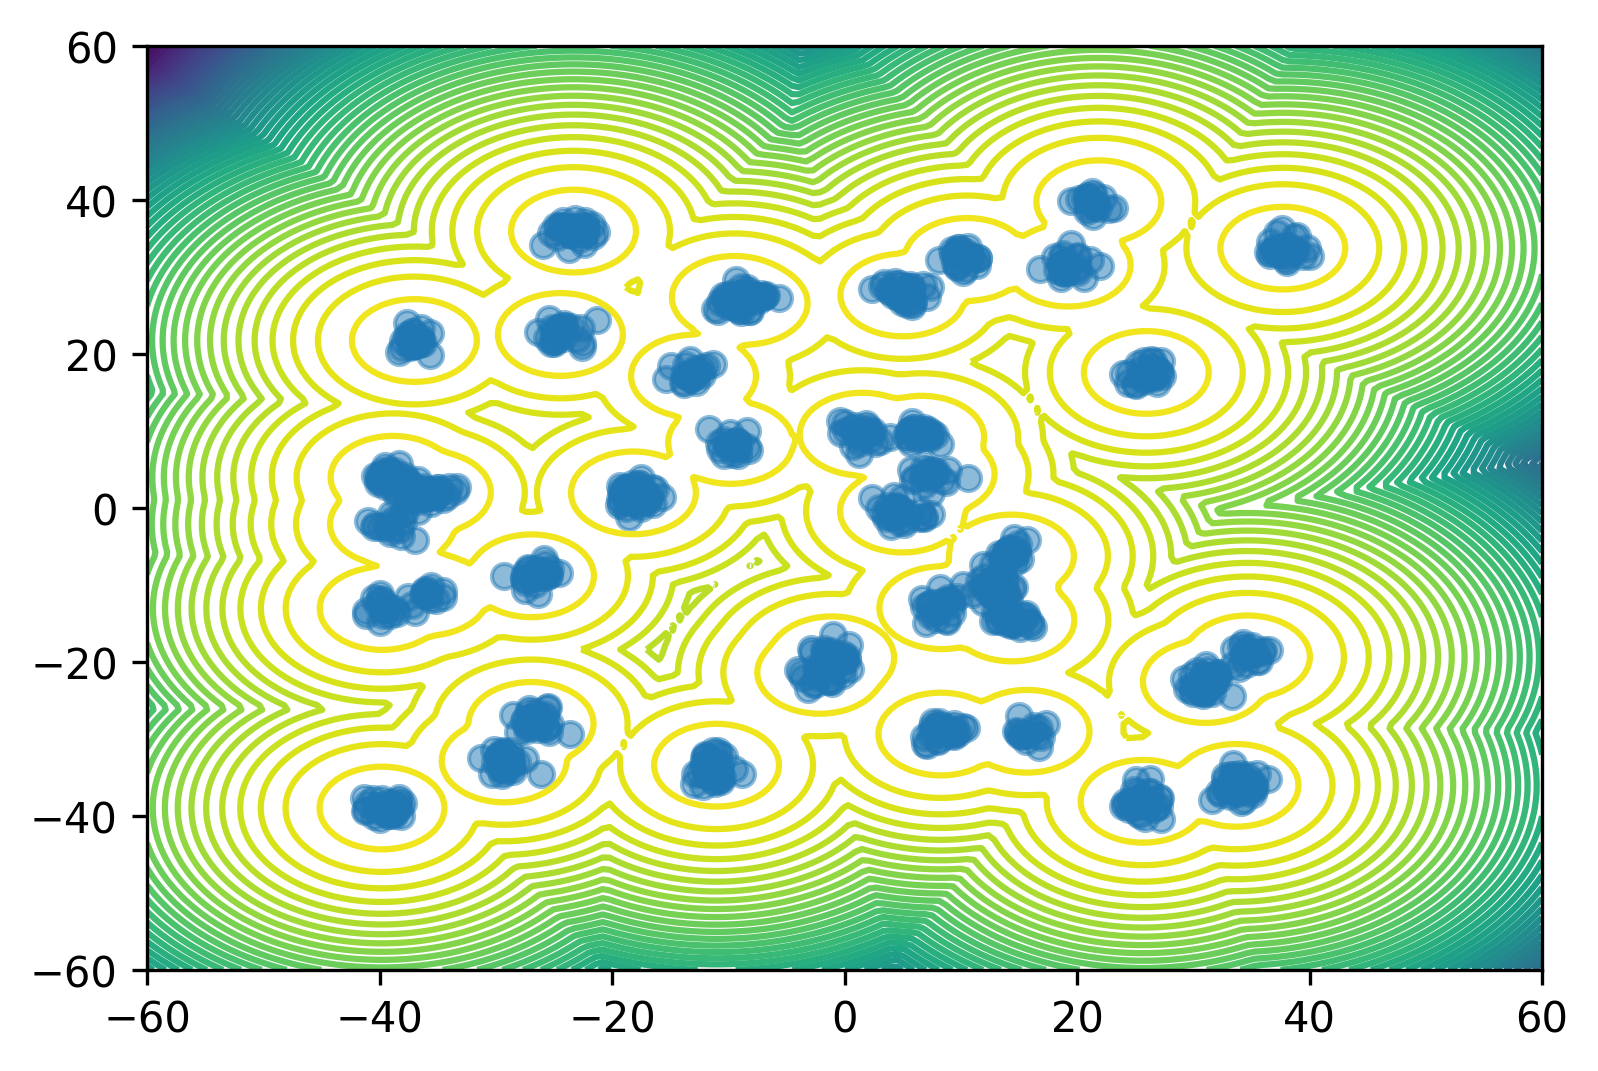

In [20]:
key, subkey = jax.random.split(key)
gmm = GMM(n_mixes=40, seed=subkey[0])
gmm.visualise(gmm.sample(jax.random.PRNGKey(0), (1000,)), [plt.gca()])

### Diffusion Bridge

In [8]:
def target_log_density(x):
    return gmm.log_prob(x)

In [22]:
def visualize_diffusion_bridge(
    log_prob_func: Callable[[jnp.ndarray], jnp.ndarray],
    T: int = 50,
    sigma_max: float = 1.0,
    sigma_min: float = 0.01,
    bound: float = 3.0,
    n_points: int = 256,
    levels: int = 20,
    output_filename: str = 'diffusion_bridge.gif'
) -> None:
    """
    Visualize the diffusion bridge from a normal distribution to the target distribution.

    Parameters:
    - log_prob_func: A function that computes the log probability of the target distribution.
                     It accepts an array of shape (..., 2) and returns an array of shape (...,).
    - T: Total number of time steps.
    - sigma_max: Initial value of sigma_t (maximum blur).
    - sigma_min: Final value of sigma_t (minimum blur).
    - bound: Range for x1 and x2 axes.
    - n_points: Number of points along each axis for the grid.
    - levels: Number of contour levels to plot.
    - output_filename: Filename to save the animation.

    Returns:
    - None. Saves the animation as a GIF file.
    """
    # Set up the grid
    x_points_dim1: jnp.ndarray = jnp.linspace(-bound, bound, n_points)
    x_points_dim2: jnp.ndarray = jnp.linspace(-bound, bound, n_points)
    x1_grid, x2_grid = jnp.meshgrid(x_points_dim1, x_points_dim2)
    x_grid: jnp.ndarray = jnp.stack([x1_grid, x2_grid], axis=-1)  # Shape: (n_points, n_points, 2)

    # Compute log_probs on the grid
    x_flat: jnp.ndarray = x_grid.reshape(-1, 2)  # Shape: (n_points * n_points, 2)
    log_probs_flat: jnp.ndarray = log_prob_func(x_flat)  # Shape: (n_points * n_points,)
    log_probs: jnp.ndarray = log_probs_flat.reshape(n_points, n_points)  # Shape: (n_points, n_points)

    # Compute q_grid
    q_grid: jnp.ndarray = jnp.exp(log_probs)
    q_grid = q_grid / (jnp.sum(q_grid) + 1e-12)  # Normalize q_grid with epsilon

    # Check for NaN or inf in q_grid
    if np.isnan(q_grid).any() or np.isinf(q_grid).any():
        print("NaN or inf values detected in q_grid")
        return

    # Time steps and corresponding sigma_t^2 values
    sigma_t_values: jnp.ndarray = jnp.linspace(sigma_max, sigma_min, T)

    # Set up the plot
    fig, ax = plt.subplots(figsize=(6, 6))

    def update(t: int) -> None:
        ax.clear()
        sigma_t: float = sigma_t_values[t]
        # Gaussian kernel k_t(y) = N(y | 0, sigma_t^2 I)
        # Compute the Gaussian kernel on the grid
        k_t_grid: jnp.ndarray = jnp.exp(- (x1_grid**2 + x2_grid**2) / (2 * sigma_t**2))
        k_t_grid = k_t_grid / jnp.sum(k_t_grid)  # Normalize kernel

        # Perform convolution via FFT
        Q: jnp.ndarray = jnp.fft.fft2(q_grid)
        K: jnp.ndarray = jnp.fft.fft2(k_t_grid)
        P: jnp.ndarray = Q * K
        p_t_grid: jnp.ndarray = jnp.fft.ifft2(P)
        p_t_grid_real: jnp.ndarray = jnp.real(p_t_grid)
        p_t_grid_real = jnp.clip(p_t_grid_real, a_min=0)  # Ensure non-negative

        total_sum = jnp.sum(p_t_grid_real) + 1e-12  # Add epsilon
        p_t_grid_real = p_t_grid_real / total_sum  # Normalize

        # Debugging: Check for NaN values
        if np.isnan(p_t_grid_real).any():
            print(f"NaN values detected in p_t_grid_real at time t={t}")
            return
        if total_sum == 0 or jnp.isnan(total_sum):
            print(f"Sum of p_t_grid_real is zero or NaN at time t={t}")
            return

        # Plot contours
        levels_array: jnp.ndarray = jnp.linspace(jnp.min(p_t_grid_real), jnp.max(p_t_grid_real), levels)
        contour = ax.contourf(x1_grid, x2_grid, p_t_grid_real, levels=levels_array, cmap='viridis')
        ax.set_title(f"Time t = {t}, σ_t^2 = {sigma_t**2:.4f}")
        ax.set_xlabel("x1")
        ax.set_ylabel("x2")
        return contour

    # Create animation
    anim = FuncAnimation(fig, update, frames=T, interval=200)

    # Save the animation as a GIF
    anim.save(output_filename, writer=PillowWriter(fps=5))
    plt.close()

    print(f"Animation saved as '{output_filename}'.")

# Call the function to execute the visualization
visualize_diffusion_bridge(
    log_prob_func=target_log_density,
    T=50,
    sigma_max=1.0,
    sigma_min=0.01,
    bound=60.0,
    n_points=256,
    levels=20,
    output_filename='diffusion_bridge.gif'
)


NaN values detected in p_t_grid_real at time t=49
Animation saved as 'diffusion_bridge.gif'.
